In [83]:
import torch

# 获取当前安装的 PyTorch 版本
current_version = torch.__version__
print(f"Current PyTorch version: {current_version}")


Current PyTorch version: 2.3.0+cu121


In [3]:
pip install torch --upgrade

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 58.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 58.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 62.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 129.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 29.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 32.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 43.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 33.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 44.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# New Begin!!

### Data

In [2]:
from surprise import Dataset

# 下载并加载数据集
data = Dataset.load_builtin('ml-1m')

# 获取数据文件的路径
data_path = data.ratings_file
print(f"Data file path: {data_path}")

Data file path: /root/.surprise_data/ml-1m/ml-1m/ratings.dat


In [3]:
import random
import numpy as np 
import pandas as pd 
import torch

import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader

class NCF_Data(object):
    def __init__(self, ratings, num_ng=4, num_ng_test=99, seed=42):
        self.ratings = ratings
        self.num_ng = num_ng
        self.num_ng_test = num_ng_test
        batch_size=64
        self.batch_size = batch_size

        self.preprocess_ratings = self._reindex(self.ratings)

        self.user_pool = set(self.ratings['user_id'].unique())
        self.item_pool = set(self.ratings['item_id'].unique())

        self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
        self.negatives = self._negative_sampling(self.preprocess_ratings)
        random.seed(seed)
    
    def _reindex(self, ratings):
        user_list = list(ratings['user_id'].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}

        item_list = list(ratings['item_id'].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}

        ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
        ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
        ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
        return ratings

    def _leave_one_out(self, ratings):
        ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
        test = ratings.loc[ratings['rank_latest'] == 1]
        train = ratings.loc[ratings['rank_latest'] > 1]
        assert train['user_id'].nunique() == test['user_id'].nunique(), 'Not Match Train User with Test User'
        return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]
    
    def _negative_sampling(self, ratings):
        interact_status = (
            ratings.groupby('user_id')['item_id']
            .apply(set)
            .reset_index()
            .rename(columns={'item_id': 'interacted_items'}))
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
        return interact_status[['user_id', 'negative_items', 'negative_samples']]

    def get_train_instance(self):
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
        for row in train_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in range(self.num_ng):
                users.append(int(row.user_id))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = Rating_Dataset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def get_test_instance(self):
        users, items, ratings = [], [], []
        test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
        for row in test_ratings.itertuples():
            users.append(int(row.user_id))
            items.append(int(row.item_id))
            ratings.append(float(row.rating))
            for i in getattr(row, 'negative_samples'):
                users.append(int(row.user_id))
                items.append(int(i))
                ratings.append(float(0))
        dataset = Rating_Dataset(
            user_list=users,
            item_list=items,
            rating_list=ratings)
        return DataLoader(dataset, batch_size=self.num_ng_test + 1, shuffle=False, num_workers=4)

class Rating_Dataset(Dataset):
    def __init__(self, user_list, item_list, rating_list):
        super(Rating_Dataset, self).__init__()
        self.user_list = user_list
        self.item_list = item_list
        self.rating_list = rating_list

    def __len__(self):
        return len(self.user_list)

    def __getitem__(self, idx):
        user = self.user_list[idx]
        item = self.item_list[idx]
        rating = self.rating_list[idx]
        
        return (
            torch.tensor(user, dtype=torch.long),
            torch.tensor(item, dtype=torch.long),
            torch.tensor(rating, dtype=torch.float)
        )

### Model

In [4]:
import torch
import torch.nn as nn

class Generalized_Matrix_Factorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32):
        super(Generalized_Matrix_Factorization, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_size)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_size)

        self.output_layer = nn.Linear(in_features=self.embedding_size, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.output_layer(element_product)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

# 这里先定义的是四层的。如果 layers=[64]，即层数为 1，模型会有一个全连接层，输入大小为 embedding_size * 2，输出大小为 64。
# 如果 layers=[64, 32]，即层数为 2，模型会有两个全连接层，第一个全连接层输入大小为 embedding_size * 2，输出大小为 64；
# 第二个全连接层输入大小为 64，输出大小为 32。
class Multi_Layer_Perceptron(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32, layers=[64, 32, 16, 8]):
        super(Multi_Layer_Perceptron, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.layers = layers

        # 定义用户层
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_size)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_size)

        # 定义全链接层
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # 定义输出层
        self.output_layer = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
        logits = self.output_layer(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass



class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size_mf=32, layers=[64, 32, 16, 8], dropout=0.2):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_mf = embedding_size_mf
        self.factor_num_mlp = int(layers[0]/2)
        self.layers = layers
        self.dropout = dropout

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())

        self.output_layer = nn.Linear(in_features=layers[-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)
        
        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                
        nn.init.xavier_uniform_(self.output_layer.weight)

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.output_layer(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

## Evaluation

In [5]:
import numpy as np
import torch


def hit(ng_item, pred_items):
    if ng_item in pred_items:
        return 1
    return 0


def ndcg(ng_item, pred_items):
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index+2))
    return 0


def metrics(model, test_loader, top_k, device):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item).squeeze()
#         print(predictions.size(0))
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(
                item, indices).cpu().numpy().tolist()

        ng_item = item[0].item()
        HR.append(hit(ng_item, recommends))
        NDCG.append(ndcg(ng_item, recommends))

    return np.mean(HR), np.mean(NDCG)

## Training

每次换不同的模型进行训练

batch size：每次训练模型时所使用的样本数。大→收敛快，但内存占用大；小→更多的更新步骤，收敛更稳定但慢。

learning rate：模型每次更新时调整权重的步长。大→模型快速收敛，但可能收敛不稳定或跳过最优解；小→收敛更稳定，但慢&可能陷入局部最优。

Epoch：完成一次完整的训练集训练的过程。一个 epoch 表示模型已经看过所有的训练样本一次。通常，一个训练过程由多个epoch组成，以便模型多次学习整个数据集。

Top-k：模型训练和评估中常用的概念，特别是在推荐系统和信息检索中。它指的是从模型预测的结果中选取前 k 个最相关或得分最高的项目。例如，在推荐系统中，top-10 推荐表示从模型生成的推荐列表中选取前 10 个项目。

In [6]:
import os
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

ratings = pd.read_csv('/root/.surprise_data/ml-1m/ml-1m/ratings.dat', sep='::', engine='python', names=['user_id', 'item_id', 'rating', 'timestamp'])
data = NCF_Data(ratings)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

/tmp/ipykernel_43718/108687278.py:54: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
/tmp/ipykernel_43718/108687278.py:60: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epochs = 30
top_k = 10
num_users = ratings['user_id'].nunique()+1
num_items = ratings['item_id'].nunique()+1

gmf_model = Generalized_Matrix_Factorization(num_users, num_items).to(device)
mlp_model = Multi_Layer_Perceptron(num_users, num_items).to(device)
neumf_model = NeuMF(num_users, num_items).to(device)

loss_function = nn.BCELoss()
optimizer_gmf = torch.optim.Adam(gmf_model.parameters(), lr=0.001)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
optimizer_neumf = torch.optim.Adam(neumf_model.parameters(), lr=0.001)

HRs_gmf = []
NDCGs_gmf = []
HRs_mlp = []
NDCGs_mlp = []
HRs_neumf = []
NDCGs_neumf = []

#### training of gmf

In [ ]:
# 保存模型参数
save_path = './saved_models'

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, epochs + 1):
    gmf_model.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_gmf.zero_grad()
        gmf_prediction = gmf_model(user, item).squeeze()
        gmf_loss = loss_function(gmf_prediction, label)
        gmf_loss.backward()
        optimizer_gmf.step()

    gmf_model.eval()

    HR_gmf, NDCG_gmf = metrics(gmf_model, test_loader, top_k, device)

    HRs_gmf.append(HR_gmf)
    NDCGs_gmf.append(NDCG_gmf)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_gmf), np.mean(NDCG_gmf)))
     # 保存模型参数
    torch.save(gmf_model.state_dict(), f'{save_path}/gmf_model_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_gmf', exist_ok=True)
np.save('./results_gmf/HRs_gmf.npy', HRs_gmf)
np.save('./results_gmf/NDCGs_gmf.npy', NDCGs_gmf)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 | Time: 244.86s
GMF | HR: 0.1068 | NDCG: 0.0506
Epoch: 2 | Time: 254.55s
GMF | HR: 0.4278 | NDCG: 0.2338
Epoch: 3 | Time: 254.73s
GMF | HR: 0.4614 | NDCG: 0.2516
Epoch: 4 | Time: 258.73s
GMF | HR: 0.5063 | NDCG: 0.2769
Epoch: 5 | Time: 269.83s
GMF | HR: 0.5490 | NDCG: 0.3011
Epoch: 6 | Time: 258.92s
GMF | HR: 0.5765 | NDCG: 0.3252


如果不小心训练断掉了，可以加载上次训练时模型的参数，接着训练：

In [ ]:
total_epochs = 30  # 总共计划训练的 epoch 数
start_epoch =   # 从第几个 epoch 开始继续训练
save_path = './saved_models'

# 加载上次训练的模型参数
gmf_model.load_state_dict(torch.load(f'{save_path}/gmf_model_epoch_{start_epoch - 1}.pth'))

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

# 继续训练
for epoch in range(start_epoch, total_epochs + 1):
    gmf_model.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_gmf.zero_grad()
        gmf_prediction = gmf_model(user, item).squeeze()
        gmf_loss = loss_function(gmf_prediction, label)
        gmf_loss.backward()
        optimizer_gmf.step()

    gmf_model.eval()

    HR_gmf, NDCG_gmf = metrics(gmf_model, test_loader, top_k, device)

    HRs_gmf.append(HR_gmf)
    NDCGs_gmf.append(NDCG_gmf)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_gmf), np.mean(NDCG_gmf)))

    # 保存模型参数
    torch.save(gmf_model.state_dict(), f'{save_path}/gmf_model_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_gmf', exist_ok=True)
np.save('./results_gmf/HRs_gmf.npy', HRs_gmf)
np.save('./results_gmf/NDCGs_gmf.npy', NDCGs_gmf)

调用每个epoch后训练得到的模型

Model: gmf_model_epoch_1.pth | HR: 0.1066 | NDCG: 0.0499
Model: gmf_model_epoch_2.pth | HR: 0.4293 | NDCG: 0.2357
Model: gmf_model_epoch_3.pth | HR: 0.4680 | NDCG: 0.2537
Model: gmf_model_epoch_4.pth | HR: 0.5088 | NDCG: 0.2772
Model: gmf_model_epoch_5.pth | HR: 0.5460 | NDCG: 0.2984
Model: gmf_model_epoch_6.pth | HR: 0.5793 | NDCG: 0.3235
Model: gmf_model_epoch_7.pth | HR: 0.5959 | NDCG: 0.3340
Model: gmf_model_epoch_8.pth | HR: 0.6109 | NDCG: 0.3475
Model: gmf_model_epoch_9.pth | HR: 0.6156 | NDCG: 0.3510
Model: gmf_model_epoch_10.pth | HR: 0.6247 | NDCG: 0.3573
Model: gmf_model_epoch_11.pth | HR: 0.6346 | NDCG: 0.3637
Model: gmf_model_epoch_12.pth | HR: 0.6348 | NDCG: 0.3657
Model: gmf_model_epoch_13.pth | HR: 0.6421 | NDCG: 0.3719
Model: gmf_model_epoch_14.pth | HR: 0.6386 | NDCG: 0.3684
Model: gmf_model_epoch_15.pth | HR: 0.6409 | NDCG: 0.3709
Model: gmf_model_epoch_16.pth | HR: 0.6381 | NDCG: 0.3693
Model: gmf_model_epoch_17.pth | HR: 0.6427 | NDCG: 0.3741
Model: gmf_model_epoch_

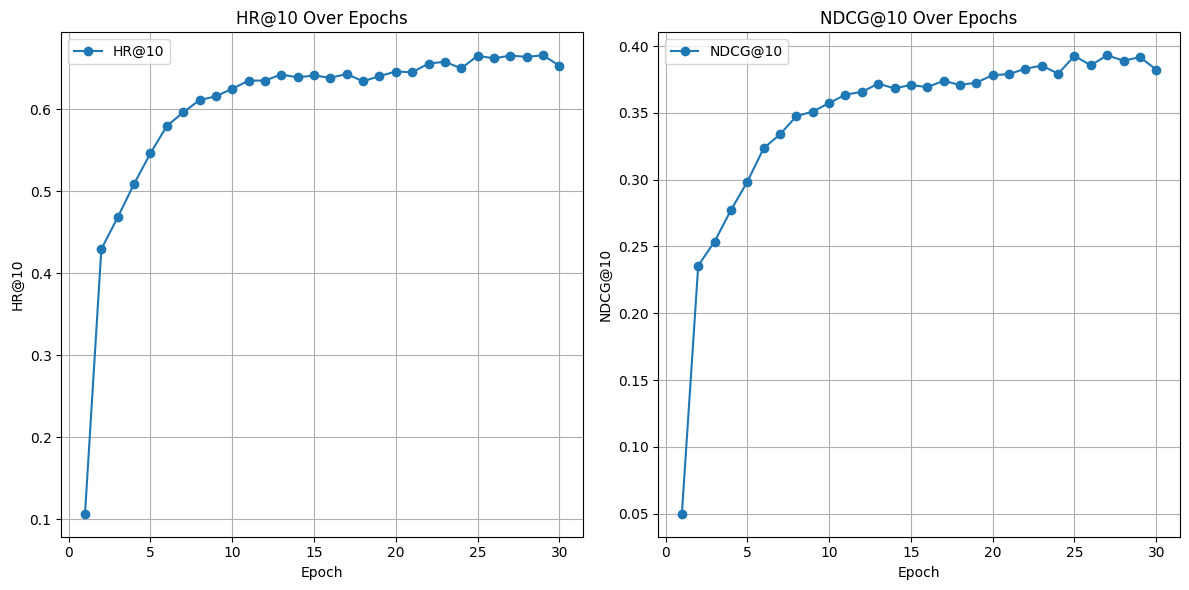

In [40]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import re

# 假设你已经定义了 GMF 模型和 metrics 函数
# from your_model import GMF, metrics  # 导入你的 GMF 模型和评估函数
# from your_data_loader import load_movielens_data, get_train_test_loader  # 导入数据加载函数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 加载数据集
# train_data, test_data = load_movielens_data()
# train_loader, test_loader = get_train_test_loader(train_data, test_data, batch_size=256)

# ratings = pd.read_csv('/root/.surprise_data/ml-1m/ml-1m/ratings.dat', sep='::', engine='python', names=['user_id', 'item_id', 'rating', 'timestamp'])
# data = NCF_Data(ratings)
# train_loader = data.get_train_instance()
# test_loader = data.get_test_instance()

# 保存 HR_gmf 和 NDCG_gmf 的列表
HRs_gmf = []
NDCGs_gmf = []

# 获取 saved_models 文件夹中的所有模型文件，注意这里不能直接对这个文件夹下的所有文件！！！不然就不会按顺序而是按1→10→11这种！
model_files = sorted([f for f in os.listdir('saved_models') if f.endswith('.pth')],
                     key=lambda x: int(re.findall(r'\d+', x)[0]))

# 定义模型参数
num_users, num_items = 6040, 3706  # 示例值，实际值请根据你的数据集调整
factors = 8  # 示例因子数，实际值请根据你的模型设置调整

# 逐个加载模型并评估
for model_file in model_files:
    # 加载模型
    model_path = os.path.join('saved_models', model_file)
    # gmf_model = GMF(num_users, num_items, factors)
    gmf_model.load_state_dict(torch.load(model_path))
    gmf_model.to(device)
    
    # 评估模型
    HR_gmf, NDCG_gmf = metrics(gmf_model, test_loader, top_k=10, device=device)
    
    # 记录评估结果
    HRs_gmf.append(np.mean(HR_gmf))
    NDCGs_gmf.append(np.mean(NDCG_gmf))
    
    print(f"Model: {model_file} | HR: {np.mean(HR_gmf):.4f} | NDCG: {np.mean(NDCG_gmf):.4f}")

# 绘制 HR_gmf 和 NDCG_gmf 的折线图
epochs = list(range(1, len(model_files) + 1))

plt.figure(figsize=(12, 6))

# 绘制 HR_gmf 折线图
plt.subplot(1, 2, 1)
plt.plot(epochs, HRs_gmf, marker='o', label='HR@10')
plt.title('HR@10 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('HR@10')
plt.legend()
plt.grid(True)

# 绘制 NDCG_gmf 折线图
plt.subplot(1, 2, 2)
plt.plot(epochs, NDCGs_gmf, marker='o', label='NDCG@10')
plt.title('NDCG@10 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('NDCG@10')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

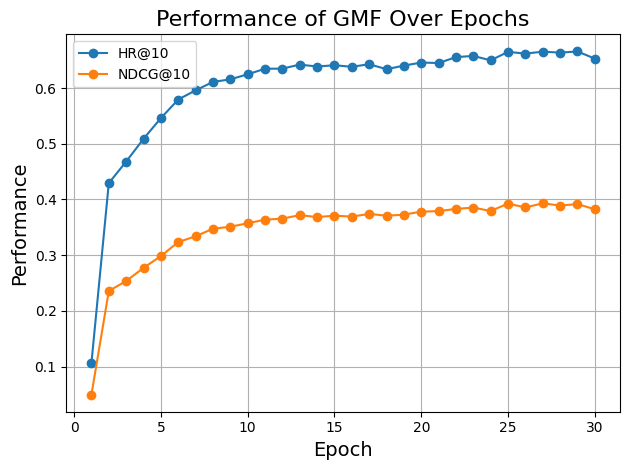

In [41]:
# 绘制 HR_gmf 和 NDCG_gmf 折线图
plt.plot(epochs, HRs_gmf, marker='o', label='HR@10')
plt.plot(epochs, NDCGs_gmf, marker='o', label='NDCG@10')
plt.title('Performance of GMF Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### training of MLP:

In [ ]:
# 保存模型参数
save_path = './saved_models_mlp'

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, epochs + 1):
    mlp_model.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_mlp.zero_grad()
        mlp_prediction = mlp_model(user, item).squeeze()
        mlp_loss = loss_function(mlp_prediction, label)
        mlp_loss.backward()
        optimizer_mlp.step()

    mlp_model.eval()

    HR_mlp, NDCG_mlp = metrics(mlp_model, test_loader, top_k, device)

    HRs_mlp.append(HR_mlp)
    NDCGs_mlp.append(NDCG_mlp)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_mlp), np.mean(NDCG_mlp)))
     # 保存模型参数
    torch.save(mlp_model.state_dict(), f'{save_path}/mlp_model_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_mlp', exist_ok=True)
np.save('./results_mlp/HRs_mlp.npy', HRs_gmf)
np.save('./results_mlp/NDCGs_mlp.npy', NDCGs_gmf)

Epoch: 1 | Time: 252.35s
GMF | HR: 0.5247 | NDCG: 0.2905
Epoch: 2 | Time: 296.01s
GMF | HR: 0.5444 | NDCG: 0.3002
Epoch: 3 | Time: 305.00s
GMF | HR: 0.5624 | NDCG: 0.3105
Epoch: 4 | Time: 303.11s
GMF | HR: 0.5738 | NDCG: 0.3197
Epoch: 5 | Time: 294.20s
GMF | HR: 0.5813 | NDCG: 0.3239
Epoch: 6 | Time: 312.33s
GMF | HR: 0.5874 | NDCG: 0.3327
Epoch: 7 | Time: 286.24s
GMF | HR: 0.5889 | NDCG: 0.3332
Epoch: 8 | Time: 261.74s
GMF | HR: 0.5962 | NDCG: 0.3373
Epoch: 9 | Time: 254.21s
GMF | HR: 0.5980 | NDCG: 0.3411
Epoch: 10 | Time: 277.65s
GMF | HR: 0.6033 | NDCG: 0.3422


如果断了，中途重新开始训练

In [ ]:
total_epochs = 30  # 总共计划训练的 epoch 数
start_epoch = 26  # 从第几个 epoch 开始继续训练
save_path = './saved_models_mlp'

# 加载上次训练的模型参数
mlp_model.load_state_dict(torch.load(f'{save_path}/mlp_model_epoch_{start_epoch - 1}.pth'))

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

# 继续训练
for epoch in range(start_epoch, total_epochs + 1):
    mlp_model.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_mlp.zero_grad()
        mlp_prediction = mlp_model(user, item).squeeze()
        mlp_loss = loss_function(mlp_prediction, label)
        mlp_loss.backward()
        optimizer_mlp.step()

    mlp_model.eval()

    HR_mlp, NDCG_mlp = metrics(mlp_model, test_loader, top_k, device)

    HRs_mlp.append(HR_mlp)
    NDCGs_mlp.append(NDCG_mlp)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_mlp), np.mean(NDCG_mlp)))

    # 保存模型参数
    torch.save(mlp_model.state_dict(), f'{save_path}/mlp_model_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_mlp', exist_ok=True)
np.save('./results_mlp/HRs_mlp.npy', HRs_gmf)
np.save('./results_mlp/NDCGs_mlp.npy', NDCGs_gmf)

读取所有模型的参数并绘制折线图

Model: mlp_model_epoch_1.pth | HR: 0.5247 | NDCG: 0.2905
Model: mlp_model_epoch_2.pth | HR: 0.5444 | NDCG: 0.3002
Model: mlp_model_epoch_3.pth | HR: 0.5624 | NDCG: 0.3105
Model: mlp_model_epoch_4.pth | HR: 0.5738 | NDCG: 0.3197
Model: mlp_model_epoch_5.pth | HR: 0.5813 | NDCG: 0.3239
Model: mlp_model_epoch_6.pth | HR: 0.5874 | NDCG: 0.3327
Model: mlp_model_epoch_7.pth | HR: 0.5889 | NDCG: 0.3332
Model: mlp_model_epoch_8.pth | HR: 0.5962 | NDCG: 0.3373
Model: mlp_model_epoch_9.pth | HR: 0.5980 | NDCG: 0.3411
Model: mlp_model_epoch_10.pth | HR: 0.6033 | NDCG: 0.3422
Model: mlp_model_epoch_11.pth | HR: 0.6012 | NDCG: 0.3417
Model: mlp_model_epoch_12.pth | HR: 0.6040 | NDCG: 0.3445
Model: mlp_model_epoch_13.pth | HR: 0.6079 | NDCG: 0.3467
Model: mlp_model_epoch_14.pth | HR: 0.5980 | NDCG: 0.3441
Model: mlp_model_epoch_15.pth | HR: 0.6079 | NDCG: 0.3484
Model: mlp_model_epoch_16.pth | HR: 0.6041 | NDCG: 0.3456
Model: mlp_model_epoch_17.pth | HR: 0.6083 | NDCG: 0.3498
Model: mlp_model_epoch_

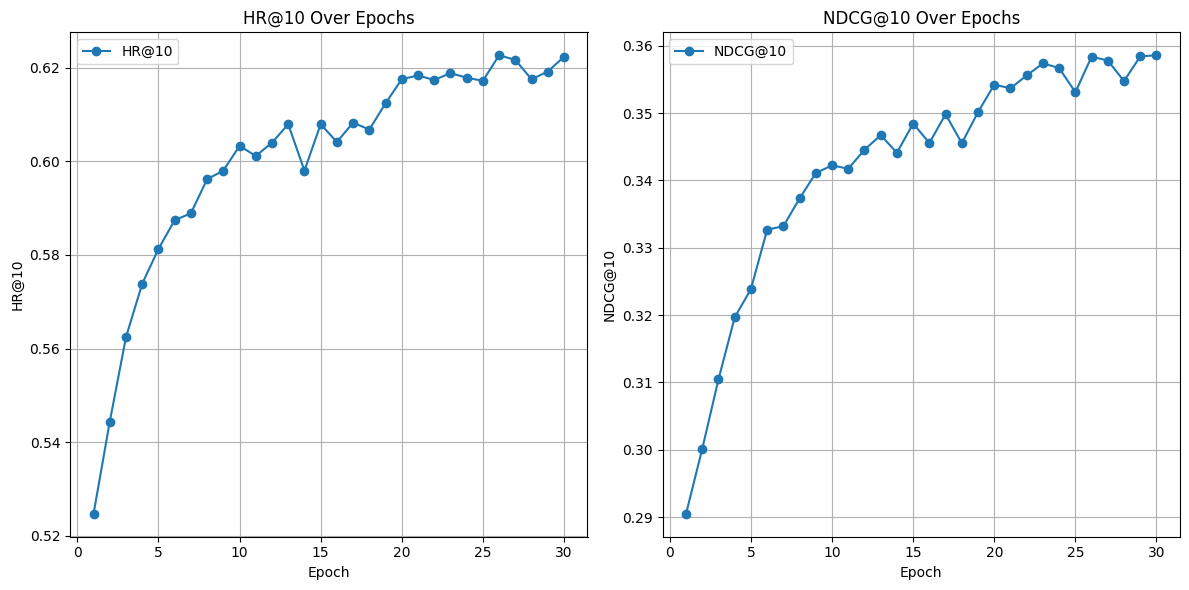

In [38]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经定义了 GMF 模型和 metrics 函数
# from your_model import GMF, metrics  # 导入你的 GMF 模型和评估函数
# from your_data_loader import load_movielens_data, get_train_test_loader  # 导入数据加载函数

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 加载数据集
# train_data, test_data = load_movielens_data()
# train_loader, test_loader = get_train_test_loader(train_data, test_data, batch_size=256)

# ratings = pd.read_csv('/root/.surprise_data/ml-1m/ml-1m/ratings.dat', sep='::', engine='python', names=['user_id', 'item_id', 'rating', 'timestamp'])
# data = NCF_Data(ratings)
# train_loader = data.get_train_instance()
# test_loader = data.get_test_instance()

# 保存 HR_gmf 和 NDCG_gmf 的列表
HRs_mlp = []
NDCGs_mlp = []

# 获取 saved_models 文件夹中的所有模型文件，注意这里不能直接对这个文件夹下的所有文件！！！不然就不会按顺序而是按1→10→11这种！
model_files = sorted([f for f in os.listdir('saved_models_mlp') if f.endswith('.pth')],
                     key=lambda x: int(re.findall(r'\d+', x)[0]))

# 定义模型参数
num_users, num_items = 6040, 3706  # 示例值，实际值请根据你的数据集调整
factors = 8  # 示例因子数，实际值请根据你的模型设置调整

# 逐个加载模型并评估
for model_file in model_files:
    # 加载模型
    model_path = os.path.join('saved_models_mlp', model_file)
    # gmf_model = GMF(num_users, num_items, factors)
    mlp_model.load_state_dict(torch.load(model_path))
    mlp_model.to(device)
    
    # 评估模型
    HR_mlp, NDCG_mlp = metrics(mlp_model, test_loader, top_k=10, device=device)
    
    # 记录评估结果
    HRs_mlp.append(np.mean(HR_mlp))
    NDCGs_mlp.append(np.mean(NDCG_mlp))
    
    print(f"Model: {model_file} | HR: {np.mean(HR_mlp):.4f} | NDCG: {np.mean(NDCG_mlp):.4f}")

# 绘制 HR_mlp 和 NDCG_mlp 的折线图
epochs = list(range(1, len(model_files) + 1))

plt.figure(figsize=(12, 6))

# 绘制 HR_mlp 折线图
plt.subplot(1, 2, 1)
plt.plot(epochs, HRs_mlp, marker='o', label='HR@10')
plt.title('HR@10 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('HR@10')
plt.legend()
plt.grid(True)

# 绘制 NDCG_mlp 折线图
plt.subplot(1, 2, 2)
plt.plot(epochs, NDCGs_mlp, marker='o', label='NDCG@10')
plt.title('NDCG@10 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('NDCG@10')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

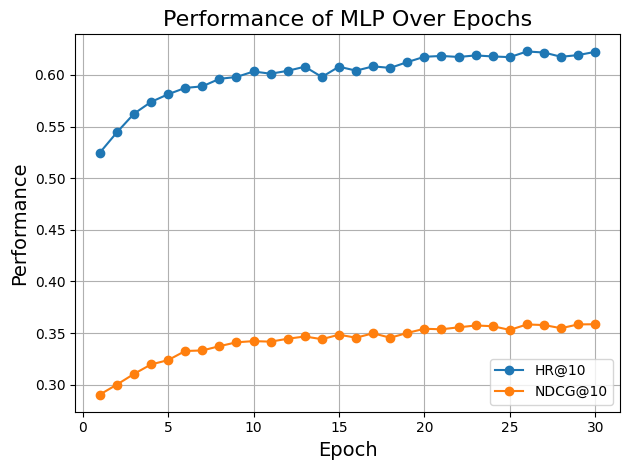

In [39]:
epochs = list(range(1, 30 + 1))
# 绘制 HR_gmf 和 NDCG_gmf 折线图
plt.plot(epochs, HRs_mlp, marker='o', label='HR@10')
plt.plot(epochs, NDCGs_mlp, marker='o', label='NDCG@10')
plt.title('Performance of MLP Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### training of Neumf:

In [26]:
# 保存模型参数
save_path = './saved_models_neumf'

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, epochs + 1):
    neumf_model.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_neumf.zero_grad()
        neumf_prediction = neumf_model(user, item).squeeze()
        neumf_loss = loss_function(neumf_prediction, label)
        neumf_loss.backward()
        optimizer_neumf.step()

    neumf_model.eval()

    HR_neumf, NDCG_neumf = metrics(neumf_model, test_loader, top_k, device)

    HRs_neumf.append(HR_neumf)
    NDCGs_neumf.append(NDCG_neumf)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("NeuMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_neumf), np.mean(NDCG_neumf)))
     # 保存模型参数
    torch.save(neumf_model.state_dict(), f'{save_path}/neumf_model_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('results_neumf', exist_ok=True)
np.save('./results_neumf/HRs_neumf.npy', HRs_neumf)
np.save('./results_neumf/NDCGs_neumf.npy', NDCGs_neumf)

Epoch: 1 | Time: 312.04s
NeuMF | HR: 0.6260 | NDCG: 0.3581
Epoch: 2 | Time: 279.68s
NeuMF | HR: 0.6474 | NDCG: 0.3784
Epoch: 3 | Time: 339.89s
NeuMF | HR: 0.6581 | NDCG: 0.3861
Epoch: 4 | Time: 323.68s
NeuMF | HR: 0.6669 | NDCG: 0.3906
Epoch: 5 | Time: 314.85s
NeuMF | HR: 0.6661 | NDCG: 0.3900
Epoch: 6 | Time: 246.49s
NeuMF | HR: 0.6697 | NDCG: 0.3933
Epoch: 7 | Time: 313.86s
NeuMF | HR: 0.6609 | NDCG: 0.3910
Epoch: 8 | Time: 318.87s
NeuMF | HR: 0.6639 | NDCG: 0.3913
Epoch: 9 | Time: 332.94s
NeuMF | HR: 0.6641 | NDCG: 0.3946
Epoch: 10 | Time: 315.03s
NeuMF | HR: 0.6675 | NDCG: 0.3955
Epoch: 11 | Time: 289.11s
NeuMF | HR: 0.6579 | NDCG: 0.3920
Epoch: 12 | Time: 256.89s
NeuMF | HR: 0.6662 | NDCG: 0.3940
Epoch: 13 | Time: 304.53s
NeuMF | HR: 0.6728 | NDCG: 0.3986
Epoch: 14 | Time: 313.91s
NeuMF | HR: 0.6641 | NDCG: 0.3939
Epoch: 15 | Time: 302.73s
NeuMF | HR: 0.6623 | NDCG: 0.3906
Epoch: 16 | Time: 335.82s
NeuMF | HR: 0.6669 | NDCG: 0.3916
Epoch: 17 | Time: 317.63s
NeuMF | HR: 0.6662 | ND

In [ ]:
total_epochs = 30  # 总共计划训练的 epoch 数  
start_epoch =   # 从第几个 epoch 开始继续训练  
save_path = './saved_models_neumf'  
  
# 加载上次训练的模型参数  
neumf_model.load_state_dict(torch.load(f'{save_path}/neumf_model_epoch_{start_epoch - 1}.pth'))  
  
# 创建保存目录  
os.makedirs(save_path, exist_ok=True)  
  
# 继续训练  
for epoch in range(start_epoch, total_epochs + 1):  
    neumf_model.train()  
    start_time = time.time()  
  
    for user, item, label in train_loader:  
        user = user.to(device)  
        item = item.to(device)  
        label = label.to(device)  
  
        optimizer_neumf.zero_grad()  # 假设这是为neumf模型创建的优化器  
        neumf_prediction = neumf_model(user, item).squeeze()  
        neumf_loss = loss_function(neumf_prediction, label)  
        neumf_loss.backward()  
        optimizer_neumf.step()  
  
    neumf_model.eval()  
  
    HR_neumf, NDCG_neumf = metrics(neumf_model, test_loader, top_k, device)  
  
    HRs_neumf.append(HR_neumf)  # 确保这个列表是已经初始化的  
    NDCGs_neumf.append(NDCG_neumf)  # 确保这个列表是已经初始化的  
  
    elapsed_time = time.time() - start_time  
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))  
    print("NeuMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_neumf), np.mean(NDCG_neumf)))  
  # 保存模型参数  
    torch.save(neumf_model.state_dict(), f'{save_path}/neumf_model_epoch_{epoch}.pth')
    
print("Training finished.")
os.makedirs('./results_neumf', exist_ok=True)  # 修改保存结果的目录名  
np.save('./results_neumf/HRs_neumf.npy', HRs_neumf)  # 修改保存结果的文件名  
np.save('./results_neumf/NDCGs_neumf.npy', NDCGs_neumf)  # 修改保存结果的文件名

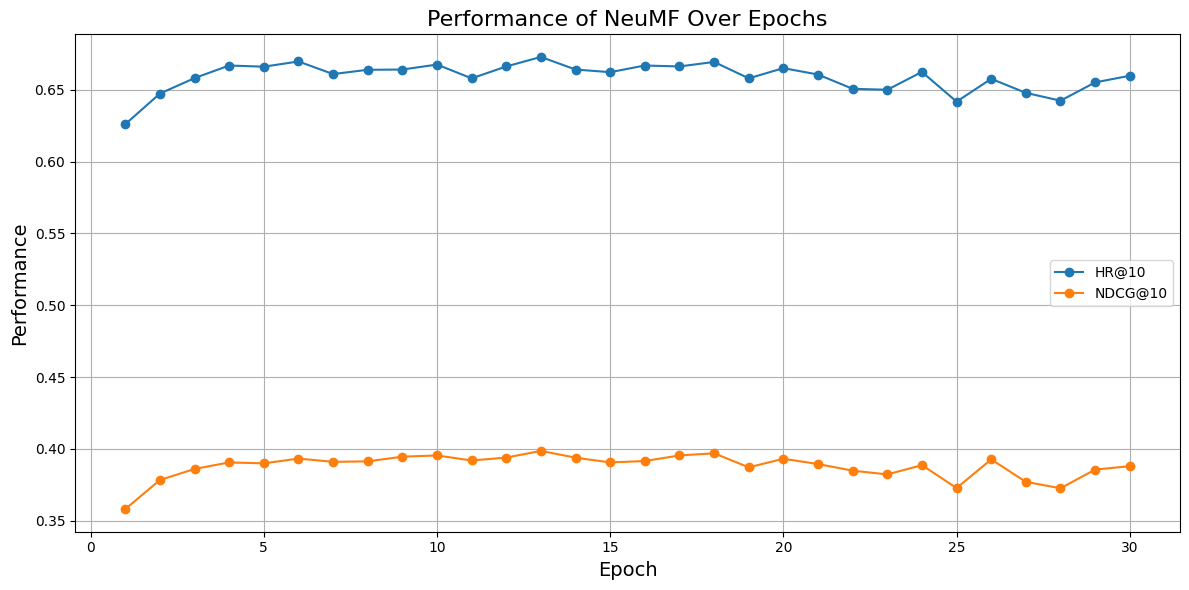

In [35]:
epochs = 30

# 绘制 HR 和 NDCG 的折线图
epochs = list(range(1, epochs + 1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, HRs_neumf, marker='o', label='HR@10')
plt.plot(epochs, NDCGs_neumf, marker='o', label='NDCG@10')
plt.title('Performance of NeuMF Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Performance', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Reproduction of the ablation study of MLP with different layers

#### 三层

In [54]:
class Multi_Layer_Perceptron_3(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32, layers=[64, 32, 16]):
        super(Multi_Layer_Perceptron_3, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.layers = layers

        # 定义用户层
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_size)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_size)

        # 定义全链接层
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # 定义输出层
        self.output_layer = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
        logits = self.output_layer(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

In [55]:
mlp_model_3 = Multi_Layer_Perceptron_3(num_users, num_items).to(device)
#求求了要重新定义optimizer啊！！！！！！！
optimizer_mlp_3 = torch.optim.Adam(mlp_model_3.parameters(), lr=0.001)

In [57]:
epochs = 30
# 保存模型参数
save_path = './models_3_mlp'

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, epochs + 1):
    mlp_model_3.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_mlp_3.zero_grad()
        mlp_prediction = mlp_model_3(user, item).squeeze()
        mlp_loss = loss_function(mlp_prediction, label)
        mlp_loss.backward()
        optimizer_mlp_3.step()

    mlp_model_3.eval()

    HR_mlp, NDCG_mlp = metrics(mlp_model_3, test_loader, top_k, device)

    HRs_mlp.append(HR_mlp)
    NDCGs_mlp.append(NDCG_mlp)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_mlp), np.mean(NDCG_mlp)))
     # 保存模型参数
    torch.save(mlp_model_3.state_dict(), f'{save_path}/mlp_3_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_mlp_3', exist_ok=True)
np.save('./results_mlp_3/HRs_mlp.npy', HRs_gmf)
np.save('./results_mlp_3/NDCGs_mlp.npy', NDCGs_gmf)

Epoch: 1 | Time: 269.52s
GMF | HR: 0.4492 | NDCG: 0.2500
Epoch: 2 | Time: 301.40s
GMF | HR: 0.4780 | NDCG: 0.2646
Epoch: 3 | Time: 293.32s
GMF | HR: 0.4995 | NDCG: 0.2791
Epoch: 4 | Time: 281.50s
GMF | HR: 0.5278 | NDCG: 0.2932
Epoch: 5 | Time: 285.81s
GMF | HR: 0.5455 | NDCG: 0.3061
Epoch: 6 | Time: 292.65s
GMF | HR: 0.5672 | NDCG: 0.3157
Epoch: 7 | Time: 305.98s
GMF | HR: 0.5728 | NDCG: 0.3239
Epoch: 8 | Time: 289.78s
GMF | HR: 0.5775 | NDCG: 0.3250
Epoch: 9 | Time: 293.81s
GMF | HR: 0.5919 | NDCG: 0.3350
Epoch: 10 | Time: 272.42s
GMF | HR: 0.5831 | NDCG: 0.3302
Epoch: 11 | Time: 272.89s
GMF | HR: 0.5921 | NDCG: 0.3375
Epoch: 12 | Time: 292.18s
GMF | HR: 0.5925 | NDCG: 0.3362
Epoch: 13 | Time: 317.07s
GMF | HR: 0.5937 | NDCG: 0.3374
Epoch: 14 | Time: 268.36s
GMF | HR: 0.5969 | NDCG: 0.3420
Epoch: 15 | Time: 293.36s
GMF | HR: 0.5929 | NDCG: 0.3405
Epoch: 16 | Time: 295.78s
GMF | HR: 0.6012 | NDCG: 0.3455
Epoch: 17 | Time: 291.41s
GMF | HR: 0.5974 | NDCG: 0.3433
Epoch: 18 | Time: 266.9

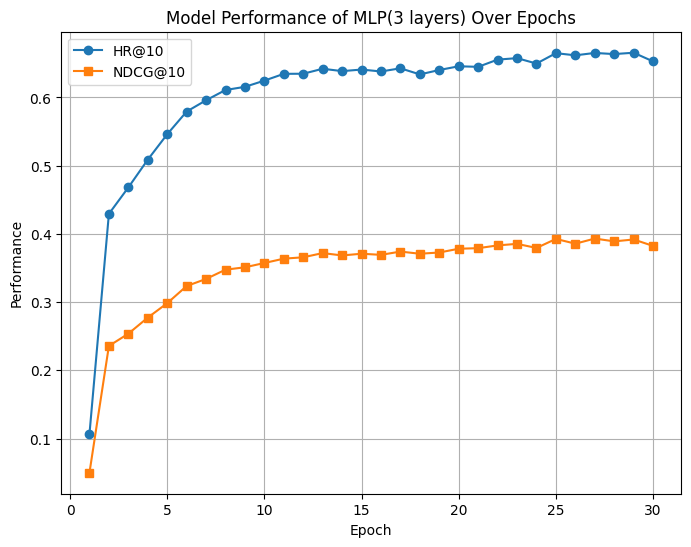

In [85]:
# 假设 HRs_mlp 和 NDCGs_mlp 是你的模型在每个 epoch 后的评估结果列表
HRs_mlp = np.load('./results_mlp_3/HRs_mlp.npy')
NDCGs_mlp = np.load('./results_mlp_3/NDCGs_mlp.npy')

# 生成 epoch 列表
epochs_list = list(range(1, len(HRs_mlp) + 1))

# 绘制 HR 和 NDCG 的折线图
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, [np.mean(hr) for hr in HRs_mlp], marker='o', label='HR@10')
plt.plot(epochs_list, [np.mean(ndcg) for ndcg in NDCGs_mlp], marker='s', label='NDCG@10')
plt.title('Model Performance of MLP(3 layers) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.grid(True)
plt.show()

#### 两层

In [62]:
class Multi_Layer_Perceptron_2(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32, layers=[64, 32]):
        super(Multi_Layer_Perceptron_2, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.layers = layers

        # 定义用户层
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_size)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_size)

        # 定义全链接层
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # 定义输出层
        self.output_layer = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
        logits = self.output_layer(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

In [63]:
mlp_model_2 = Multi_Layer_Perceptron_2(num_users, num_items).to(device)
optimizer_mlp_2 = torch.optim.Adam(mlp_model_2.parameters(), lr=0.001)

In [66]:
HRs_mlp = []
NDCGs_mlp = []
epochs = 30
# 保存模型参数
save_path = './models_2_mlp'

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, epochs + 1):
    mlp_model_2.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_mlp_2.zero_grad()
        mlp_prediction = mlp_model_2(user, item).squeeze()
        mlp_loss = loss_function(mlp_prediction, label)
        mlp_loss.backward()
        optimizer_mlp_2.step()

    mlp_model_2.eval()

    HR_mlp, NDCG_mlp = metrics(mlp_model_2, test_loader, top_k, device)

    HRs_mlp.append(HR_mlp)
    NDCGs_mlp.append(NDCG_mlp)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_mlp), np.mean(NDCG_mlp)))
     # 保存模型参数
    torch.save(mlp_model_2.state_dict(), f'{save_path}/mlp_2_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_mlp_2', exist_ok=True)
np.save('./results_mlp_2/HRs_mlp.npy', HRs_gmf)
np.save('./results_mlp_2/NDCGs_mlp.npy', NDCGs_gmf)

Epoch: 1 | Time: 296.15s
GMF | HR: 0.4780 | NDCG: 0.2601
Epoch: 2 | Time: 300.85s
GMF | HR: 0.4983 | NDCG: 0.2764
Epoch: 3 | Time: 301.04s
GMF | HR: 0.5257 | NDCG: 0.2919
Epoch: 4 | Time: 295.13s
GMF | HR: 0.5450 | NDCG: 0.3043
Epoch: 5 | Time: 279.67s
GMF | HR: 0.5576 | NDCG: 0.3119
Epoch: 6 | Time: 289.50s
GMF | HR: 0.5719 | NDCG: 0.3216
Epoch: 7 | Time: 291.70s
GMF | HR: 0.5786 | NDCG: 0.3246
Epoch: 8 | Time: 285.54s
GMF | HR: 0.5886 | NDCG: 0.3323
Epoch: 9 | Time: 287.49s
GMF | HR: 0.5912 | NDCG: 0.3343
Epoch: 10 | Time: 283.46s
GMF | HR: 0.6008 | NDCG: 0.3391
Epoch: 11 | Time: 277.00s
GMF | HR: 0.6043 | NDCG: 0.3411
Epoch: 12 | Time: 275.16s
GMF | HR: 0.6111 | NDCG: 0.3446
Epoch: 13 | Time: 284.47s
GMF | HR: 0.6103 | NDCG: 0.3455
Epoch: 14 | Time: 282.33s
GMF | HR: 0.6195 | NDCG: 0.3506
Epoch: 15 | Time: 301.21s
GMF | HR: 0.6126 | NDCG: 0.3470
Epoch: 16 | Time: 265.73s
GMF | HR: 0.6210 | NDCG: 0.3530
Epoch: 17 | Time: 265.60s
GMF | HR: 0.6228 | NDCG: 0.3568
Epoch: 18 | Time: 274.7

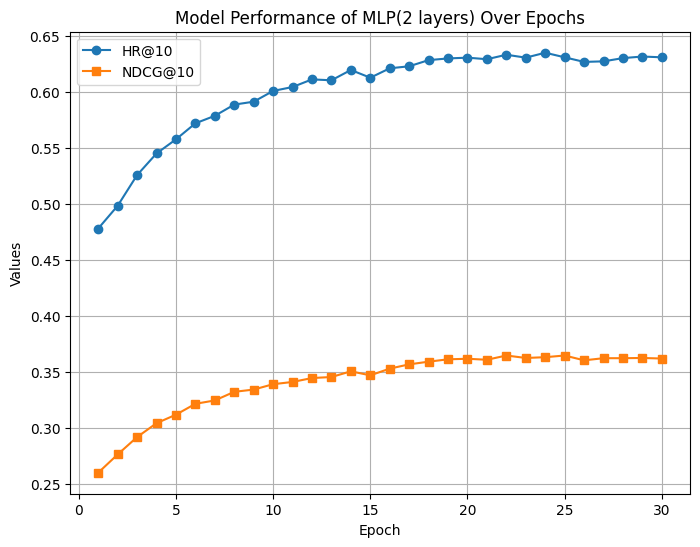

In [89]:
import matplotlib.pyplot as plt

# 数据
epochs = list(range(1, 31))
hr_values = [0.4780, 0.4983, 0.5257, 0.5450, 0.5576, 0.5719, 0.5786, 0.5886, 0.5912, 0.6008,
             0.6043, 0.6111, 0.6103, 0.6195, 0.6126, 0.6210, 0.6228, 0.6283, 0.6298, 0.6305,
             0.6291, 0.6331, 0.6305, 0.6349, 0.6308, 0.6267, 0.6272, 0.6301, 0.6315, 0.6308]
ndcg_values = [0.2601, 0.2764, 0.2919, 0.3043, 0.3119, 0.3216, 0.3246, 0.3323, 0.3343, 0.3391,
               0.3411, 0.3446, 0.3455, 0.3506, 0.3470, 0.3530, 0.3568, 0.3592, 0.3613, 0.3618,
               0.3609, 0.3647, 0.3625, 0.3632, 0.3647, 0.3604, 0.3623, 0.3623, 0.3625, 0.3620]

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(epochs, hr_values, marker='o', label='HR@10')
plt.plot(epochs, ndcg_values, marker='s', label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Model Performance of MLP(2 layers) Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### 一层

In [67]:
class Multi_Layer_Perceptron_1(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32, layers=[64]):
        super(Multi_Layer_Perceptron_1, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.layers = layers

        # 定义用户层
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_size)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_size)

        # 定义全链接层
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # 定义输出层
        self.output_layer = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
        logits = self.output_layer(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

In [68]:
mlp_model_1 = Multi_Layer_Perceptron_1(num_users, num_items).to(device)
optimizer_mlp_1 = torch.optim.Adam(mlp_model_1.parameters(), lr=0.001)

In [69]:
HRs_mlp = []
NDCGs_mlp = []
epochs = 30
# 保存模型参数
save_path = './models_1_mlp'

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, epochs + 1):
    mlp_model_1.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_mlp_1.zero_grad()
        mlp_prediction = mlp_model_1(user, item).squeeze()
        mlp_loss = loss_function(mlp_prediction, label)
        mlp_loss.backward()
        optimizer_mlp_1.step()

    mlp_model_1.eval()

    HR_mlp, NDCG_mlp = metrics(mlp_model_1, test_loader, top_k, device)

    HRs_mlp.append(HR_mlp)
    NDCGs_mlp.append(NDCG_mlp)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_mlp), np.mean(NDCG_mlp)))
     # 保存模型参数
    torch.save(mlp_model_1.state_dict(), f'{save_path}/mlp_1_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_mlp_1', exist_ok=True)
np.save('./results_mlp_1/HRs_mlp.npy', HRs_gmf)
np.save('./results_mlp_1/NDCGs_mlp.npy', NDCGs_gmf)

Epoch: 1 | Time: 244.19s
GMF | HR: 0.4507 | NDCG: 0.2486
Epoch: 2 | Time: 236.28s
GMF | HR: 0.4512 | NDCG: 0.2506
Epoch: 3 | Time: 260.63s
GMF | HR: 0.4485 | NDCG: 0.2490
Epoch: 4 | Time: 258.59s
GMF | HR: 0.4493 | NDCG: 0.2513
Epoch: 5 | Time: 259.99s
GMF | HR: 0.4475 | NDCG: 0.2488
Epoch: 6 | Time: 257.82s
GMF | HR: 0.4513 | NDCG: 0.2502
Epoch: 7 | Time: 253.75s
GMF | HR: 0.4517 | NDCG: 0.2503
Epoch: 8 | Time: 258.91s
GMF | HR: 0.4513 | NDCG: 0.2505
Epoch: 9 | Time: 269.56s
GMF | HR: 0.4512 | NDCG: 0.2507
Epoch: 10 | Time: 251.33s
GMF | HR: 0.4512 | NDCG: 0.2506
Epoch: 11 | Time: 263.00s
GMF | HR: 0.4502 | NDCG: 0.2498
Epoch: 12 | Time: 268.46s
GMF | HR: 0.4498 | NDCG: 0.2498
Epoch: 13 | Time: 285.43s
GMF | HR: 0.4508 | NDCG: 0.2498
Epoch: 14 | Time: 272.82s
GMF | HR: 0.4500 | NDCG: 0.2496
Epoch: 15 | Time: 272.24s
GMF | HR: 0.4498 | NDCG: 0.2502
Epoch: 16 | Time: 273.87s
GMF | HR: 0.4515 | NDCG: 0.2504
Epoch: 17 | Time: 233.27s
GMF | HR: 0.4503 | NDCG: 0.2500
Epoch: 18 | Time: 273.0

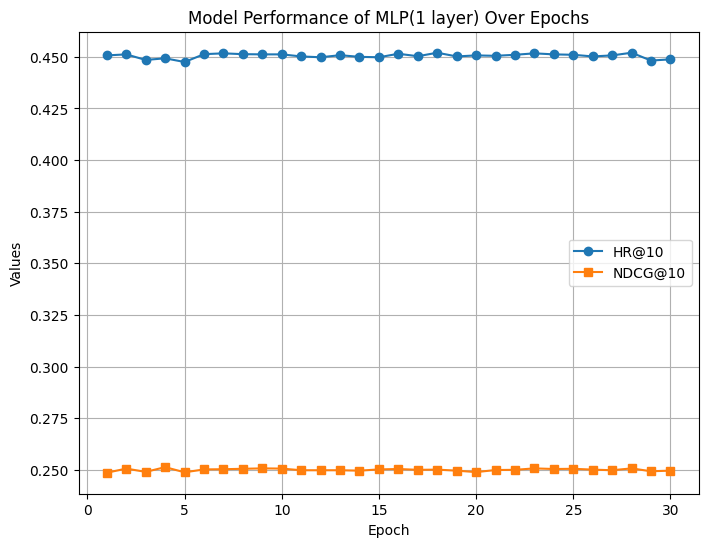

In [88]:
epochs = list(range(1, 31))
hr_values = [0.4507, 0.4512, 0.4485, 0.4493, 0.4475, 0.4513, 0.4517, 0.4513, 0.4512, 0.4512,
             0.4502, 0.4498, 0.4508, 0.4500, 0.4498, 0.4515, 0.4503, 0.4520, 0.4502, 0.4507,
             0.4505, 0.4510, 0.4517, 0.4512, 0.4510, 0.4502, 0.4507, 0.4520, 0.4482, 0.4488]
ndcg_values = [0.2486, 0.2506, 0.2490, 0.2513, 0.2488, 0.2502, 0.2503, 0.2505, 0.2507, 0.2506,
               0.2498, 0.2498, 0.2498, 0.2496, 0.2502, 0.2504, 0.2500, 0.2501, 0.2496, 0.2489,
               0.2499, 0.2500, 0.2507, 0.2504, 0.2505, 0.2501, 0.2498, 0.2507, 0.2493, 0.2496]

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(epochs, hr_values, marker='o', label='HR@10')
plt.plot(epochs, ndcg_values, marker='s', label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Model Performance of MLP(1 layer) Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### 0层

In [81]:
class Multi_Layer_Perceptron_0(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32, layers=[]):
        super(Multi_Layer_Perceptron_0, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.layers = layers

        # 定义用户层
        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_size)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_size)

        # 定义全链接层
        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        # 定义输出层
        self.output_layer = nn.Linear(in_features=[], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
        logits = self.output_layer(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

In [82]:
mlp_model_0 = Multi_Layer_Perceptron_0(num_users, num_items).to(device)
optimizer_mlp_0 = torch.optim.Adam(mlp_model_0.parameters(), lr=0.001)

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got list"

In [ ]:
HRs_mlp = []
NDCGs_mlp = []
epochs = 30
# 保存模型参数
save_path = './models_0_mlp'

# 创建保存目录
os.makedirs(save_path, exist_ok=True)

for epoch in range(1, epochs + 1):
    mlp_model_0.train()
    start_time = time.time()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)

        optimizer_mlp_0.zero_grad()
        mlp_prediction = mlp_model_0(user, item).squeeze()
        mlp_loss = loss_function(mlp_prediction, label)
        mlp_loss.backward()
        optimizer_mlp_0.step()

    mlp_model_0.eval()

    HR_mlp, NDCG_mlp = metrics(mlp_model_0, test_loader, top_k, device)

    HRs_mlp.append(HR_mlp)
    NDCGs_mlp.append(NDCG_mlp)

    elapsed_time = time.time() - start_time
    print("Epoch: {} | Time: {:.2f}s".format(epoch, elapsed_time))
    print("GMF | HR: {:.4f} | NDCG: {:.4f}".format(np.mean(HR_mlp), np.mean(NDCG_mlp)))
     # 保存模型参数
    torch.save(mlp_model_0.state_dict(), f'{save_path}/mlp_0_epoch_{epoch}.pth')

print("Training finished.")

os.makedirs('./results_mlp_0', exist_ok=True)
np.save('./results_mlp_0/HRs_mlp.npy', HRs_gmf)
np.save('./results_mlp_0/NDCGs_mlp.npy', NDCGs_gmf)